# Homework 2
- Implement an explicit Runge-Kutta integrator that takes an initial time step $h_0$ and an error tolerance $\epsilon$.
- You can use the Bogacki-Shampine method or any other method with an embedded error estimate.
- A step should be rejected if the local truncation error exceeds the tolerance.
- Test your method on the nonlinear equation $$ \begin{bmatrix} \dot u_0 \\ \dot u_1 \end{bmatrix} = \begin{bmatrix} u_1 \\ k (1-u_0^2) u_1 - u_0 \end{bmatrix} $$ for $k=2$, $k=5$, and $k=20$.
- Make a work-precision diagram for your adaptive method and for constant step sizes.
- State your conclusions or ideas (in a README, or Jupyter notebook) about appropriate (efficient, accurate, reliable) methods for this type of problem.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
TINY = 1e-10
DOFIGA = 1e10

We will test your methods on the nonlinear equation $$ \begin{bmatrix} \dot u \\ \dot v \end{bmatrix} = \begin{bmatrix} v \\ k (1-u^2) v - u \end{bmatrix} $$ for $k=2$, $k=5$, and $k=20$.

In [2]:
class RHS:
    def __init__(self, k=2):
        self.k = k
    def __repr__(self):
        return 'fcos(k={:d})'.format(self.k)
    def f(self, t, W):
        """Right-hand side function in W' = f, where
            W = [u,v]
            u' = v
            v' = k(1-u^2)v-u 
        """
        f = np.zeros((2),'float')
        f[0] = W[1]
        f[1] = self.k*(1-W[0]**2)*W[1]-W[0]
        return f

We can define function for an explicit 4th order Runge-Kutta method with following Butcher table.

| 0   ||     |     |     |     |
|---- ||---- |---- |---|----|
| 1/2 || 1/2 |     |     |     |
| 1/2 || 0   | 1/2 |     |     |
| 1   || 0   | 0   | 1   |     |
|     || 1/6 | 1/6 | 2/6 | 1/6 |

In [3]:
def RungeKutta(f, tspan, u0, t_step):
    """ Solve the initial value problem u' = f(t,u) by Runge-Kutta method.
    tspan -- list of time interval ends
    u0 -- the initial conditions u(t0) = u0,
    t_step -- time step.
    """
    def increment_4(f, t, u, t_step):
        k1 = t_step * f(t, u)
        k2 = t_step * f(t + t_step / 2., u + k1 / 2.)
        k3 = t_step * f(t + t_step / 2., u + k2 / 2.)
        k4 = t_step * f(t + t_step, u + k3)
        return (k1 + 2. * k2 + 2. * k3 + k4) / 6.
    
    t = []
    u = []
    t0, tEnd = tspan[0], tspan[-1]
    t.append(t0)
    u.append(u0)
    while abs(tEnd - t0) > TINY:
        t_step = min(t_step, tEnd - t0)
        u0 = u0 + increment_4(f, t0, u0, t_step)
        t0 = t0 + t_step
        t.append(t0)
        u.append(u0)
    return np.array(t), np.array(u)

In [4]:
def normC(u):
    norm = 0.0
    for i in u:
        norm = max(norm,abs(i))
    return norm

We can integrate our problem using this method.

In [19]:
t0, tEnd = 1.0, 10.0      # bounds
u0 = [1.0, 1.0]          # initial confitions
n = 500                    # number of points
t_step = (tEnd-t0)/(n-1)  # time step

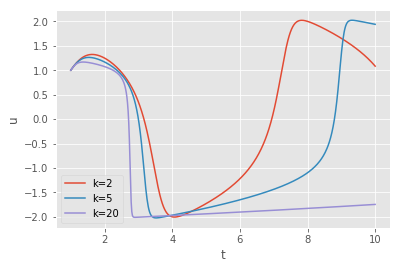

In [20]:
rhs = RHS(k=2)
t2, u2 = RungeKutta(rhs.f, [t0, tEnd], u0, t_step)
rhs = RHS(k=5)
t5, u5 = RungeKutta(rhs.f, [t0, tEnd], u0, t_step)
rhs = RHS(k=20)
t20, u20 = RungeKutta(rhs.f, [t0, tEnd], u0, t_step)

plt.plot(t2, u2[:,0], label='k=2')
plt.plot(t5, u5[:,0], label='k=5')
plt.plot(t20, u20[:,0], label='k=20')
plt.xlabel("t")
plt.ylabel("u")
plt.legend(loc=0)
plt.grid(True)
plt.show()

## Now we can use use Runge rule to estimate error
We don't know the exact solution of our problem, but we can estimate the error using Runge rule (since we know the order of the method). So, first we need to solve problem on mesh with step $2h$, and then again on mesh with step $h$.

We will use notation $U^{2h}$ for numerical solution on mesh with step $2h$, and $U^h$ for mesh with step $h$, and $\hat u$ is analitical solution. Then:
\begin{eqnarray}
U^{2h}-\hat u & = & C(2h)^p,\\
U^h - \hat u & = & Ch^p,
\end{eqnarray}
where $p$ is order of method. 
\begin{eqnarray}
U^h - U^{2h}  = Ch^p(1-2^p)
\end{eqnarray}
or
\begin{eqnarray}
Ch^p = \frac{U^h - U^{2h}}{1-2^p}.
\end{eqnarray}
We can consider two norms:
$$
	\|\Delta\|_C = \max_{1\leq n\leq N}|\Delta(t_n)|, \qquad \|\Delta\|_{l_2} = \left[1/N \sum_{n=1}^{N}\Delta^2(t_n)\right]. 
$$
Then
$$
\|\Delta\| = \|U^h-\hat u \|\approx \frac{\|U^h - U^{2h}\|}{1-2^p}.
$$
If error is greater than $\varepsilon$, then increase number of points in twice and check condition  $\|\Delta\| \leq \varepsilon$ again for new mesh. 

We also can introduce effective order: 
\begin{equation}
	p_{eff} =  \left[ \log\left( \|\Delta_{\tau}\| / \|\Delta_{\tau/2}\| \right )\right] /\log r.
\end{equation}

In [21]:
TOL = 1e-10              # tolerance
r = 2                    # coefficient of mesh refinement
p = 4                    # order of the method 

In [22]:
t, u = [], []
N_all = []
errors_all = []               # array of errors on each iteration
p_eff_all = []                # array of effective order

for k in [2, 5, 20]:
    err = DOFIGA 
    N = []                    # array of numbers of points on each iteration
    errors = []               # array of errors on each iteration
    p_eff = []                # array of effective order
    p_eff.append(p)
    counter = 0               # iteration
    n = 51                    # number of points
    t_step = (tEnd-t0)/(n-1) # time step
    
    rhs = RHS(k=k)
    t1, u1 = RungeKutta(rhs.f, [t0, tEnd], u0, t_step)
    print('\nk = ', k)
    
    while abs(err) > TOL:
        counter += 1
        t_step = t_step / 2

        t2, u2 = RungeKutta(rhs.f, [t0, tEnd], u0, t_step)

        # calculate error
        u1 = u1 - [u2[2 * i] for i in range(len(u1))]  # calculate difference in even nodes
        err = normC(u1[:,0]) / (r ** p - 1)

        print("\nN = ", len(t2), "\nerr = ", err)
        errors.append(err)
        N.append(len(t2))
        t1, u1 = t2, u2

        # effective order
        if counter > 1:
            if errors[-1] == 0.0:
                peff = p
            else:
                peff = np.log10(errors[-2] / errors[-1]) / np.log10(r)
            print("p_eff = ", peff,)
            p_eff.append(peff)

    t.append(t1)
    u.append(u1[:,0]) 
    N_all.append(N)
    errors_all.append(errors)              
    p_eff_all.append(p_eff)                


k =  2

N =  101 
err =  0.000619472950247

N =  201 
err =  5.0061644781e-05
p_eff =  3.62926369055

N =  401 
err =  3.4838458792e-06
p_eff =  3.8449529842

N =  801 
err =  2.28882048914e-07
p_eff =  3.92800457969

N =  1601 
err =  1.46024849397e-08
p_eff =  3.97031851562

N =  3201 
err =  9.21371053527e-10
p_eff =  3.98628781275

N =  6401 
err =  5.78506575977e-11
p_eff =  3.99337701

k =  5

N =  101 
err =  6.80322237064e+295

N =  201 
err =  0.00316074583866
p_eff =  991.040525492

N =  401 
err =  0.000248003016197
p_eff =  3.67183545837

N =  801 
err =  1.81330427057e-05
p_eff =  3.77366473345

N =  1601 
err =  1.2129102049e-06
p_eff =  3.9020763753

N =  3201 
err =  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in add
  if __name__ == '__main__':


7.81593384384e-08
p_eff =  3.95591068148

N =  6401 
err =  4.95291243574e-09
p_eff =  3.9800692356

N =  12801 
err =  3.11633489384e-10
p_eff =  3.99035493065

N =  25601 
err =  1.95587694189e-11
p_eff =  3.99396277146

k =  20

N =  101 
err =  2.64242693379e+21

N =  201 
err =  inf
p_eff =  -inf

N =  401 
err =  inf
p_eff =  nan

N =  801 
err =  0.00020163706315
p_eff =  inf

N =  1601 
err =  9.93868020953e-06
p_eff =  4.34256275227

N =  3201 
err =  6.28783077058e-07
p_eff =  3.9824199894


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars



N =  6401 
err =  3.82960129386e-08
p_eff =  4.037296286

N =  12801 
err =  2.37488054407e-09
p_eff =  4.01126734543

N =  25601 
err =  1.47678698899e-10
p_eff =  4.00732129543

N =  51201 
err =  9.18509712733e-12
p_eff =  4.00702296016


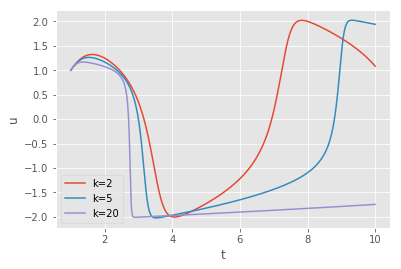

In [23]:
plt.plot(t[0], u[0], '-', label = 'k=2')
plt.plot(t[1], u[1], '-', label = 'k=5')
plt.plot(t[2], u[2], '-', label = 'k=20')
plt.xlabel("t")
plt.ylabel("u")
plt.legend(loc=0)
plt.grid(True)
plt.show()

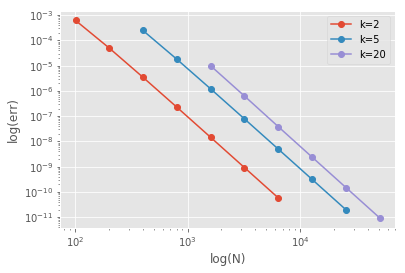

In [26]:
plt.loglog(N_all[0],errors_all[0], '-o', label = 'k=2')
plt.loglog(N_all[1][2:],errors_all[1][2:], '-o', label = 'k=5')
plt.loglog(N_all[2][4:],errors_all[2][4:], '-o', label ='k=20')
plt.legend(loc=0)
plt.xlabel("log(N)")
plt.ylabel("log(err)")
plt.grid(True)
plt.show()

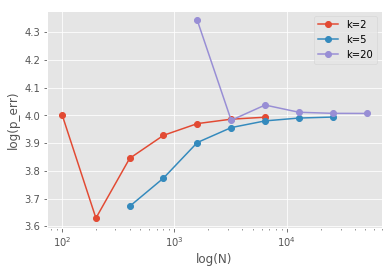

In [27]:
plt.semilogx(N_all[0], p_eff_all[0], '-o', label = 'k=2')
plt.semilogx(N_all[1][2:], p_eff_all[1][2:], '-o', label = 'k=5')
plt.semilogx(N_all[2][4:], p_eff_all[2][4:], '-o', label = 'k=20')
plt.legend(loc=0)
plt.xlabel("log(N)")
plt.ylabel("log(p_err)")
plt.grid(True)
plt.show()

We can state that our results are appropriate, when $|p_{eff}-p|<0.05$ and we don't need to refine mesh any further. 

## Runge-Kutta-Fehlberg method
One popular technique that uses Inequality for error control is the Runge-Kutta-Fehlberg method. This technique uses a Runge-Kutta method with local truncation error of order five, to estimate the local error in a Runge-Kutta method of order four. An advantage to this method is that only six evaluations of $f$ are required per step. Arbitrary Runge-Kutta methods of orders four and five used together require at least four evaluations of $f$ for the fourth-order method and an additional six for the fifth-order method, for a total of at least ten function evaluations. So the Runge-Kutta-Fehlberg method has at least a 40% decrease in the number of function evaluations over the use of a pair of arbitrary fourth- and fifth-order methods.

In [28]:
def RungeKuttaFehlberg(f, tspan, u0, t_step, TOL=1e-8):
    """
    Algorithm 5.3  in "Numerical analisys" 9th Burden Faires
    R - differense between these two methods    
    Input:
    f - function on the right side of ODE
    tspan -- list of time interval ends
    u0 -- the initial conditions u(t0) = u0,
    t_step -- time step.
    """
    
    t = []
    u = []
    t0, tEnd = tspan[0], tspan[-1]
    t.append(t0)
    u.append(u0)
    t_step_max = t_step
    t_step_min = 1e-8
    time_flag = True
    R = 1.0
    counter = 0
    
    while time_flag:

        k1 = t_step * f(t0, u0)       
        k2 = t_step * f(t0 + t_step / 4, u0 + k1 / 4)
        k3 = t_step * f(t0 + t_step * 3 / 8, u0 + k1 * 3 / 32 + k2 * 9 / 32)
        k4 = t_step * f(t0 + t_step * 12 / 13, u0 + k1 * 1932 / 2197 - k2 * 7200 / 2197 + k3 * 7296 / 2197)
        k5 = t_step * f(t0 + t_step, u0 + k1 * 439 / 216 - k2 * 8 + k3 * 3680 / 513 - k4 * 845 / 4104)
        k6 = t_step * f(t0 + t_step / 2, u0 - k1 * 8 / 27 + k2 * 2 - k3 * 3544 / 2565 + k4 * 1859 / 4104 - k5 * 11 / 40)
#         R = 1 / t_step * np.abs(1 / 360 * k1 - 128 / 4275 * k3 - 2197 / 75240 * k4 + 1 / 50 * k5 + 2 / 55 * k6)
        R = np.max(1 / t_step * np.abs(1 / 360. * k1 - 128 / 4275 * k3 - 2197 / 75240 * k4 + 1 / 50 * k5 + 2 / 55 * k6))
        if R <= TOL:
            u0 = u0 + (25 / 216 * k1 + 1408 / 2565 * k3 + 2197 / 4104 * k4 - 1 / 5 * k5)
            t0 += t_step
            t.append(t0)
            u.append(u0)
            counter += 1
        
        # Calculate new t_step   
        delta = 0.84 * (TOL / R) ** 0.25
        if delta <= 0.1:
            t_step = 0.1 * t_step
        elif delta >= 4:
            t_step = 4 * t_step
        else:
            t_step = delta * t_step
        if t_step > t_step_max:
            t_step = t_step_max

        if t0 >= tEnd:
            time_flag = False
        elif t_step < t_step_min:
            time_flag = False
            print("Minimum t_step exceeded")
        else:
            t_step = min(t_step, tEnd - t0)
    print("Number of iteration = ", counter)
    return np.array(t), np.array(u), counter

We can use this method to solve our problem.


k =  2
Number of iteration =  620

k =  5
Number of iteration =  1105

k =  20
Number of iteration =  1372


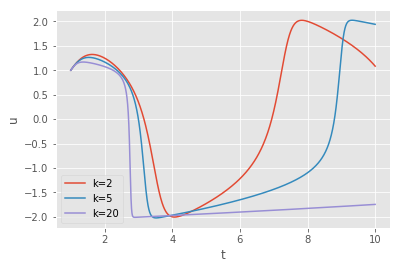

In [29]:
n = 21                    # number of points
t_step = (tEnd-t0)/(n-1) # time step
t_all, u_all = [],[]
for k in [2, 5, 20]:
    print('\nk = ', k)
    rhs = RHS(k=k)
    t, u, _ = RungeKuttaFehlberg(rhs.f, [t0, tEnd], u0, t_step, TOL=1e-8)
    t_all.append(t)
    u_all.append(u[:,0])
    
plt.plot(t_all[0], u_all[0], '-', label = 'k=2')
plt.plot(t_all[1], u_all[1], '-', label = 'k=5')
plt.plot(t_all[2], u_all[2], '-', label = 'k=20')
plt.xlabel("t")
plt.ylabel("u")
plt.legend(loc=0)
plt.grid(True)
plt.show()

In [31]:
TOL_all = [1e-2,1e-3,1e-4,1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
n_it_all = []
for k in [2, 5, 20]:
    n_it = []
    for TOL in TOL_all:
        n = 51                    # number of points
        t_step = (tEnd-t0)/(n-1) # time step
        print('\nk = {}, TOL = {}'.format(k, TOL))
        rhs = RHS(k=k)
        t, u, it = RungeKuttaFehlberg(rhs.f, [t0, tEnd], u0, t_step, TOL=TOL)
        n_it.append(it)
    n_it_all.append(n_it)


k = 2, TOL = 0.01
Number of iteration =  51

k = 2, TOL = 0.001
Number of iteration =  58

k = 2, TOL = 0.0001
Number of iteration =  78

k = 2, TOL = 1e-05
Number of iteration =  117

k = 2, TOL = 1e-06
Number of iteration =  200

k = 2, TOL = 1e-07
Number of iteration =  351

k = 2, TOL = 1e-08
Number of iteration =  620

k = 2, TOL = 1e-09
Number of iteration =  1099

k = 2, TOL = 1e-10
Number of iteration =  1951

k = 5, TOL = 0.01
Number of iteration =  66

k = 5, TOL = 0.001
Number of iteration =  87

k = 5, TOL = 0.0001
Number of iteration =  125

k = 5, TOL = 1e-05
Number of iteration =  206

k = 5, TOL = 1e-06
Number of iteration =  357

k = 5, TOL = 1e-07
Number of iteration =  625

k = 5, TOL = 1e-08
Number of iteration =  1105

k = 5, TOL = 1e-09
Number of iteration =  1957

k = 5, TOL = 1e-10
Number of iteration =  3473

k = 20, TOL = 0.01
Number of iteration =  154

k = 20, TOL = 0.001
Number of iteration =  179

k = 20, TOL = 0.0001
Number of iteration =  224

k = 20, T

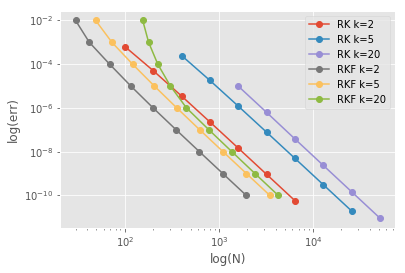

In [15]:
plt.loglog(np.array(N_all[0]),errors_all[0], '-o', label = 'RK k=2')
plt.loglog(np.array(N_all[1])[2:],errors_all[1][2:], '-o', label = 'RK k=5')
plt.loglog(np.array(N_all[2])[4:],errors_all[2][4:], '-o', label ='RK k=20')

plt.loglog(np.array(n_it_all[0]),TOL_all, '-o', label = 'RKF k=2')
plt.loglog(np.array(n_it_all[1]),TOL_all, '-o', label = 'RKF k=5')
plt.loglog(np.array(n_it_all[2]),TOL_all, '-o', label = 'RKF k=20')

plt.legend(loc=0)
plt.xlabel("log(N)")
plt.ylabel("log(err)")
plt.grid(True)
plt.show()

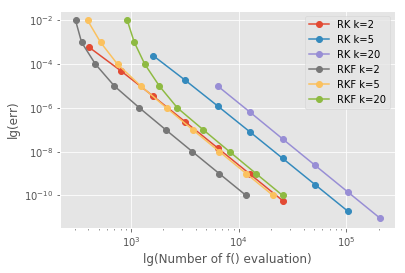

In [32]:
plt.loglog(np.array(N_all[0])*4,errors_all[0], '-o', label = 'RK k=2')
plt.loglog(np.array(N_all[1])[2:]*4,errors_all[1][2:], '-o', label = 'RK k=5')
plt.loglog(np.array(N_all[2])[4:]*4,errors_all[2][4:], '-o', label ='RK k=20')

plt.loglog(np.array(n_it_all[0])*6,TOL_all, '-o', label = 'RKF k=2')
plt.loglog(np.array(n_it_all[1])*6,TOL_all, '-o', label = 'RKF k=5')
plt.loglog(np.array(n_it_all[2])*6,TOL_all, '-o', label = 'RKF k=20')

plt.legend(loc=0)
plt.xlabel("lg(Number of f() evaluation)")
plt.ylabel("lg(err)")
plt.grid(True)
plt.show()

We can see, that the number of $f$ evaluation for RKF is significantly smaller. It is true for functions with big gradients, since the step adaptation can adjust for such gradients, without introducing additional points in the regions with small gradirnt.